In [1]:
import matplotlib.pyplot as plt 
import matplotlib.colors as plt_colors
import matplotlib.collections as mcoll
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.lines import Line2D

### Infidelity Heatmap ###

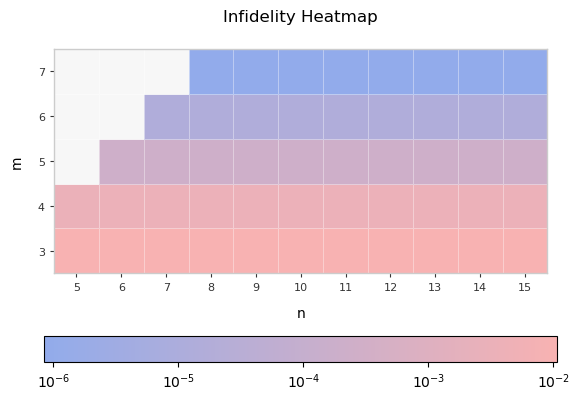

In [2]:
heat_map_data = np.load("../data/fidelity_heatmap.npy", allow_pickle=True)[0]

m_values = heat_map_data['m_values']
n_values = heat_map_data['n_values']
data = heat_map_data['data']


# Create meshgrid for cell edges
x_edges = np.arange(min(n_values)-0.5, max(n_values)+1-0.5+1)
y_edges = np.arange(min(m_values)-0.5, max(m_values)+1-0.5+1)

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Custom colormap
pastel_colors = [
    (0.15, 0.35, 0.85),   # pastel blue
    (0.95, 0.40, 0.40),   # pastel red/pink
]

cmap = plt_colors.LinearSegmentedColormap.from_list("tikz_pastel", pastel_colors, N=256)
cmap.set_bad(color="#f0f0f0")

# Plot with log normalization
im = ax.pcolormesh(
    x_edges, y_edges, data,
    cmap=cmap,
    norm=plt_colors.LogNorm(vmin=np.nanmin(data[data > 0]), vmax=np.nanmax(data)),
    edgecolors="white", linewidth=0.5, alpha=0.5
)

# Axis formatting
ax.set_xticks(n_values)
ax.set_yticks(m_values)
ax.set_xlabel("n", fontsize=10, labelpad=10)
ax.set_ylabel("m", fontsize=10, labelpad=10)
ax.set_aspect('equal')

# Smaller ticks everywhere
ax.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

# Add subtle border
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)

# Colorbar
cbar = fig.colorbar(
    im, ax=ax, orientation="horizontal",
    pad=0.2, fraction=0.085
)

# Set colorbar ticks to powers of 10
data_min = np.nanmin(data[data > 0])
data_max = np.nanmax(data)

# Find the range of powers of 10 that span our data
min_power = int(np.floor(np.log10(data_min)))
max_power = int(np.ceil(np.log10(data_max)))

# Generate powers of 10 within our data range
powers_of_10 = []
for power in range(min_power, max_power + 1):
    tick_value = 10**power
    if data_min <= tick_value <= data_max:
        powers_of_10.append(tick_value)

# Set the ticks and labels
cbar.set_ticks(powers_of_10)
cbar.set_ticklabels([f'$10^{{{int(np.log10(tick))}}}$' for tick in powers_of_10])
# Remove minor ticks from colorbar
cbar.ax.tick_params(which='minor', size=0)  # Hide minor tick lines
cbar.ax.minorticks_off()  # Turn off minor ticks completely



# Title
ax.set_title("Infidelity Heatmap", fontsize=12, pad=20)

plt.tight_layout()
plt.savefig("mnplot.pdf", dpi=300)
plt.show()

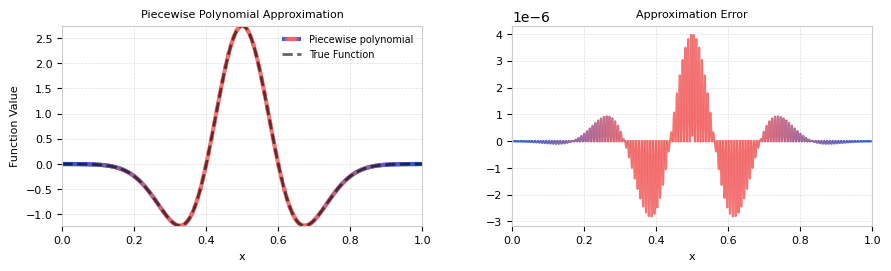

In [3]:
poly_data = np.load("../data/polyapprox.npy", allow_pickle=True)
ref_data, ylim = poly_data[-2], poly_data[-1]
approx_segments, error_segments = poly_data[:64],poly_data[64:128]

pastel_colors = [
    (0.15, 0.35, 0.85),   # pastel blue
    (0.95, 0.40, 0.40),   # pastel red/pink
]
cmap = plt_colors.LinearSegmentedColormap.from_list("tikz_pastel", pastel_colors+pastel_colors[::-1], N=128)
colors = [cmap(i) for i in np.linspace(0, 1, 128)] 

class HandlerGradientLine(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        x_legend = np.linspace(xdescent, xdescent + width, 100)
        y_legend = np.full_like(x_legend, ydescent + height / 2)

        points = np.array([x_legend, y_legend]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = mcoll.LineCollection(
            segments,
            cmap=orig_handle.cmap,
            linewidth=3,
            transform=trans,
        )
        lc.set_array(np.linspace(0, 1, len(x_legend) - 1))
        return [lc]


def gradient_legend_line(cmap):
    return mcoll.LineCollection([], cmap=cmap)


# Figure
fig, ax = plt.subplots(1, 2, figsize=(9, 2.5), sharex=True)

# Plot approximation + error
for i, (seg, err) in enumerate(zip(approx_segments, error_segments)):
    ax[0].plot(seg["x"], seg["y"], color=colors[i], linewidth=3, alpha=0.9)
    ax[0].plot(seg["x_reflect"], seg["y"], color=colors[i], linewidth=3, alpha=0.9)

    ax[1].plot(err["x"], err["y"], color=colors[i], linewidth=1.5, alpha=0.9)
    ax[1].plot(err["x_reflect"], err["y_reflect"], color=colors[i], linewidth=1.5, alpha=0.9)

# Reference function
ref_line, = ax[0].plot(
    ref_data["x"],
    ref_data["y"],
    "--",
    color="k",
    linewidth=2,
    alpha=0.6,
)

# Legend
gradient_handle = gradient_legend_line(cmap)
ax[0].legend(
    [gradient_handle, ref_line],
    ["Piecewise polynomial", "True Function"],
    fontsize=7,
    frameon=False,
    handler_map={mcoll.LineCollection: HandlerGradientLine()},
)

# Labels, limits, styling
ax[0].set_title("Piecewise Polynomial Approximation", fontsize=8)
ax[1].set_title("Approximation Error", fontsize=8)

ax[0].set_ylabel("Function Value", fontsize=8)
ax[0].set_xlabel("x", fontsize=8)
ax[1].set_xlabel("x", fontsize=8)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
ax[0].set_ylim(ylim['min'], ylim['max'])

for axi in ax:
    axi.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    axi.tick_params(labelsize=8)
    for spine in axi.spines.values():
        spine.set_edgecolor("#cccccc")

# Layout & save
plt.subplots_adjust(left=0.08, bottom=0.12, right=0.98, top=0.92, wspace=0.25)
plt.savefig("polynomial_approx.pdf", dpi=300, bbox_inches="tight")
plt.show()

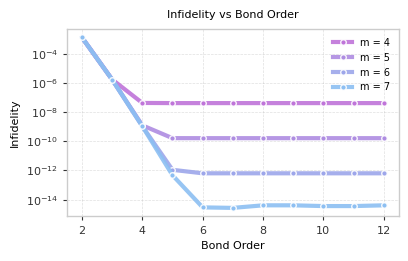

In [4]:
trunc_data = np.load("../data/truncdata.npy", allow_pickle=True)

pastel_colors_v2 = [
    (0.75, 0.45, 0.85),   # pastel purple
    (0.55, 0.75, 0.95),   # pastel sky blue
]

cmap = plt_colors.LinearSegmentedColormap.from_list("compatible_pastel", pastel_colors_v2, N=4)
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

fig, ax = plt.subplots(figsize=(4, 2.5))  # Half width since it's a single plot

plt.yscale('log')
for idx, d in enumerate(trunc_data):
    plt.plot(d['x_values'], d['y_values'], 
             color=colors[idx], 
             linewidth=3, 
             alpha=0.9,
             label=f'm = {idx + 4}',
             marker='o',
             markersize=4,
             markerfacecolor=colors[idx],
             markeredgecolor='white',
             markeredgewidth=1)

# Styling to match your first plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

# Set spine colors to match
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)

# Labels and title
plt.xlabel("Bond Order", fontsize=8, labelpad=4)
plt.ylabel("Infidelity", fontsize=8, labelpad=4)
plt.title("Infidelity vs Bond Order", fontsize=8, pad=8)

# Legend with same styling as first plot
plt.legend(loc="best", fontsize=7, frameon=False)
plt.subplots_adjust(
    left=0.12,
    bottom=0.15,
    right=0.95,
    top=0.90
)

plt.savefig("trunc_plot.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()


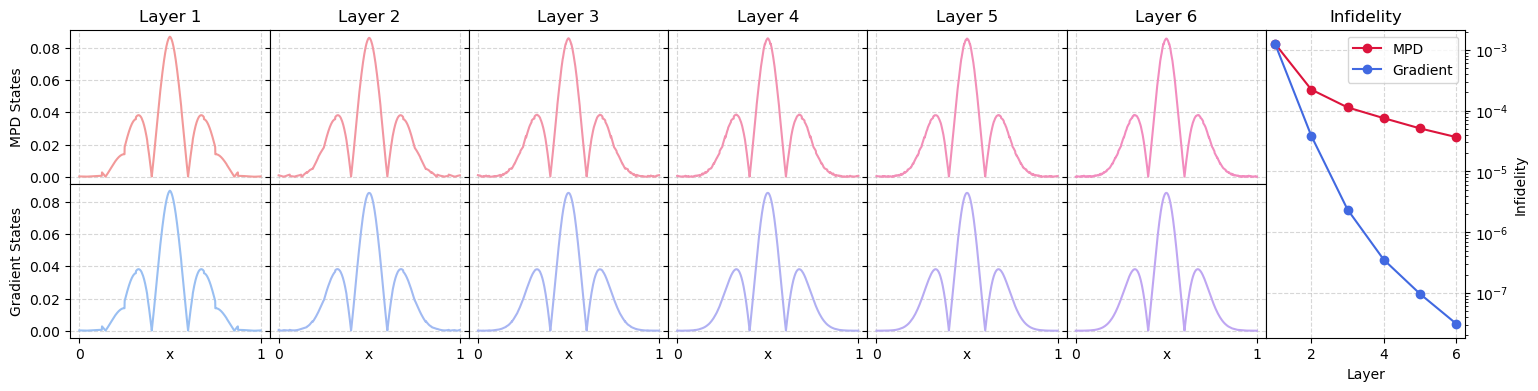

In [5]:
opt_data = np.load('../data/mps_opt_data.npy',allow_pickle=True)[0]
layers = opt_data['layers']
opt_layers = opt_data['opt_layers']
results  = opt_data['results']
num_layers = len(layers)

mpd_infid  = opt_data['mpd_infid']
mpd_states  = opt_data['mpd_states']
grad_infid  = opt_data['grad_infid']
grad_states  = opt_data['grad_states']

x = opt_data['x']

# Define warm pastel gradient (top row)
warm_pastel = [
    (0.95, 0.60, 0.60),   # pastel red
    (0.95, 0.55, 0.75),   # pastel pink
]
warm_cmap = plt_colors.LinearSegmentedColormap.from_list("warm_pastel", warm_pastel, N=num_layers)
warm_colors = [warm_cmap(i) for i in np.linspace(0, 1, num_layers)]

# Define cool pastel gradient (bottom row)
cool_pastel = [
    (0.60, 0.75, 0.95),   # pastel blue
    (0.75, 0.65, 0.95),   # pastel lavender
]
cool_cmap = plt_colors.LinearSegmentedColormap.from_list("cool_pastel", cool_pastel, N=num_layers)
cool_colors = [cool_cmap(i) for i in np.linspace(0, 1, num_layers)]

# -------------------------
# Figure setup
# -------------------------
fig = plt.figure(figsize=(3*num_layers, 4))
gs = gridspec.GridSpec(2, num_layers+1, figure=fig)  # +1 for infidelity axis

# Subplot grid
ax = np.empty((2, num_layers+1), dtype=object)
for row in range(2):
    for col in range(num_layers):
        ax[row, col] = fig.add_subplot(gs[row, col])
ax_inf = fig.add_subplot(gs[:, num_layers])
ax[:, num_layers] = ax_inf

# -------------------------
# Data & plots
# -------------------------
for i in range(num_layers):
    ax[0, i].plot(x, abs(mpd_states[i]), color=warm_colors[i])
    ax[1, i].plot(x, abs(grad_states[i]), color=cool_colors[i])
# -------------------------
# Infidelity plot
# -------------------------
ax_inf.set_yscale('log')
ax_inf.plot(range(1, num_layers+1), mpd_infid, '-o', label='MPD', color='crimson')
ax_inf.plot(range(1, num_layers+1), grad_infid, '-o', label='Gradient', color='royalblue')
ax_inf.set_xlabel('Layer')
ax_inf.set_ylabel('Infidelity')
ax_inf.legend()
ax_inf.set_title('Infidelity')

# -------------------------
# Formatting
# -------------------------
for row in range(2):
    all_ylims = [ax[row, col].get_ylim() for col in range(num_layers)]
    ymin = min(lim[0] for lim in all_ylims)
    ymax = max(lim[1] for lim in all_ylims)
    for col in range(num_layers):
        ax[row, col].set_ylim(ymin, ymax)

        if col == 0:
            ax[row, col].tick_params(labelleft=True)
        else:
            ax[row, col].tick_params(labelleft=False)

        ax[row, col].grid(True, linestyle="--", alpha=0.5)

        # x-ticks
        ax[row, col].set_xticks([0, 1])
        if row == 1:
            ax[row, col].set_xticklabels(["0", "1"])
            ax[row, col].set_xlabel('x', labelpad=-10)
        else:
            ax[row, col].set_xticklabels([])

# Titles and labels
for i in range(num_layers):
    ax[0, i].set_title(f'Layer {i+1}')
ax[0, 0].set_ylabel('MPD States')
ax[1, 0].set_ylabel('Gradient States')

# Infidelity axis formatting
ax_inf.yaxis.tick_right()
ax_inf.yaxis.set_label_position("right")
ax_inf.grid(True, linestyle="--", alpha=0.5)

plt.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("layer_plot.pdf", dpi=300)
plt.show()


-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

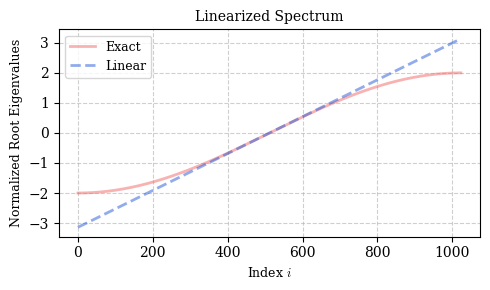

In [6]:
plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif"
})

data = np.load('../data/spec_plot.npy', allow_pickle=True)[0]
exact_spec = data['exact']
lin_spec = data['linear']

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(list(range(len(exact_spec))), exact_spec, label=r"Exact", 
         color=(0.95, 0.40, 0.40), linewidth=2, alpha = 0.5)

plt.plot(list(range(len(lin_spec))), lin_spec, label=r"Linear", 
         color=(0.15, 0.35, 0.85), linestyle="--", linewidth=2, alpha = 0.5)

# Aesthetics
plt.title("Linearized Spectrum", fontsize=10)
plt.xlabel("Index $i$", fontsize=9)
plt.ylabel("Normalized Root Eigenvalues", fontsize=9)
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("Spectra.pdf", bbox_inches='tight', dpi=300)
plt.show()

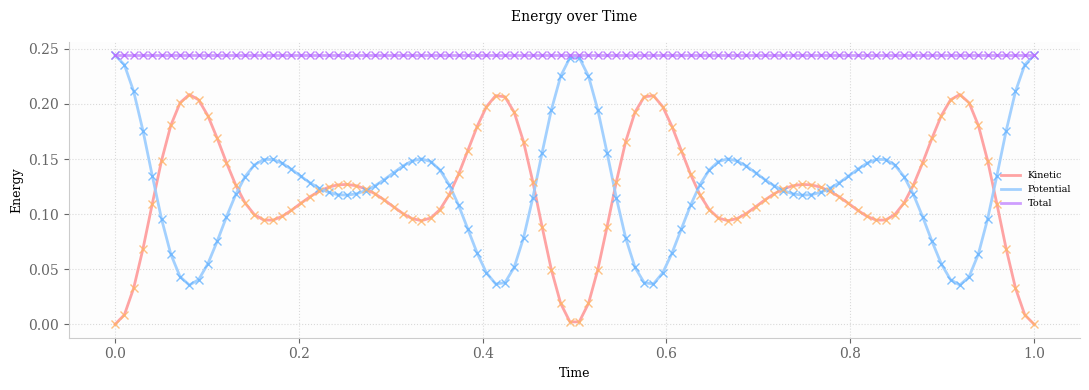

In [7]:
energies = np.load('../data/energies.npy', allow_pickle=True)[0]
T_exact = np.array(energies['exact_kin'])
U_exact = np.array(energies['exact_pot'])
circ_E = np.array(energies['circ'])

plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif"
})


# Physics-themed pastel colors
colors = {
    'kinetic': '#FF9999',      # Soft red for kinetic energy
    'potential': '#99CCFF',    # Soft blue for potential energy  
    'total': '#CC99FF',        # Soft purple for total energy
    'kinetic_data': '#FFB366', # Soft orange for kinetic data
    'potential_data': '#66B3FF', # Soft cyan for potential data
    'total_data': '#B366FF'    # Soft magenta for total data
}

plt.figure(figsize=(11, 4))

# Your original code with enhanced styling
plt.plot(np.linspace(0, 1, 100), T_exact, 
         color=colors['kinetic'], linewidth=2, alpha=0.9, 
         label='Kinetic')

plt.plot(np.linspace(0, 1, 100), U_exact, 
         color=colors['potential'], linewidth=2, alpha=0.9, 
         label='Potential')

plt.plot(np.linspace(0, 1, 100), [E[0] for E in circ_E], 'x', 
         color=colors['potential_data'], linewidth=0, alpha=0.8, 
)

plt.plot(np.linspace(0, 1, 100), [E[1] for E in circ_E], 'x', 
         color=colors['kinetic_data'], linewidth=0, alpha=0.8, 
        )

plt.plot(np.linspace(0, 1, 100), T_exact+U_exact, 
         color=colors['total'], linewidth=2, alpha=0.95, 
         label='Total')

plt.plot(np.linspace(0, 1, 100), [E[0]+E[1] for E in circ_E], "x", 
         color=colors['total_data'], linewidth=0, alpha=0.8, 
         )

# Enhanced aesthetics
plt.grid(True, alpha=0.3, linestyle=':', color='#888')
plt.xlabel('Time', fontsize=9)
plt.ylabel('Energy', fontsize=9)
plt.title('Energy over Time', fontsize=10, pad=15)

# Better legend - more compact
plt.legend(loc='center right', frameon=False, 
          fontsize=7, framealpha=0.95, ncol=1, columnspacing=1.5)

# Clean styling  
plt.gca().set_facecolor('#fdfdfd')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#ccc')
ax.spines['bottom'].set_color('#ccc')
ax.tick_params(colors='#666')

plt.tight_layout()
plt.savefig("energy.pdf", dpi=300)
plt.show()

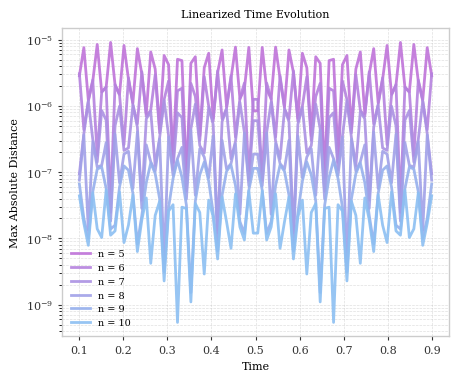

In [8]:
evo_errors = np.load("../data/evo_errors.npy",allow_pickle=True)[0]
times = np.array(evo_errors['times'])
nlist = np.array(evo_errors['times'])
fids = np.array(evo_errors['fids'])


# Define compatible pastel colormap (slightly different from first plot)
pastel_colors_v2 = [
    (0.75, 0.45, 0.85),   # pastel purple
    (0.55, 0.75, 0.95),   # pastel sky blue
]
import matplotlib.colors as plt_colors
fig, ax = plt.subplots(figsize=(5, 4))

# Create colormap for the 4 lines (m = 4, 5, 6, 7)
cmap = plt_colors.LinearSegmentedColormap.from_list("compatible_pastel", pastel_colors_v2, N=6)
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

plt.xlabel("Time", fontsize=8, labelpad=4)
plt.ylabel("Max Absolute Distance", fontsize=8, labelpad=4)
plt.title("Linearized Time Evolution", fontsize=8, pad=8)


plt.yscale('log')

for idx, (n, y_values) in enumerate(zip(n_values, fids)):
    
    plt.plot(times[10:-10], y_values[10:-10], 
             color=colors[idx], 
             linewidth=2, 
             alpha=0.9,
             label=f'n = {n}',
             markersize=4,
             markerfacecolor=colors[idx],
             markeredgecolor='white',
             markeredgewidth=1)

# Set spine colors to match
for spine in ax.spines.values():
    spine.set_edgecolor('#cccccc')
    spine.set_linewidth(1)


plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)
plt.tick_params(axis='both', which='major', labelsize=8, length=3, width=0.8, colors='#333333')

plt.legend(loc="best", fontsize=7, frameon=False)

plt.savefig("Linear Error.pdf", bbox_inches='tight', dpi=300)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------

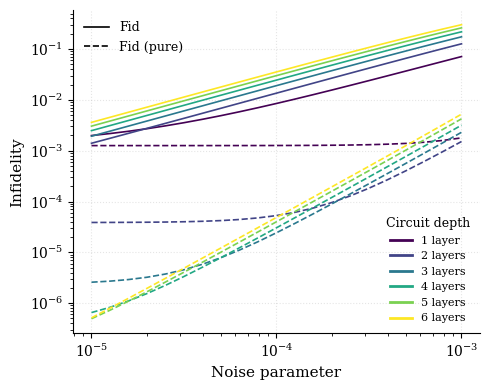

In [9]:
pure_data = np.load("../data/purified.npy",allow_pickle=True)[0]

Fid_pure = pure_data['Fid_pure']
Fid = pure_data['Fid']

R_pure = pure_data['R_pure']
R = pure_data['R']

# --- Global aesthetics ---
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.size": 10,
    "axes.linewidth": 0.8
})

fig, ax = plt.subplots(figsize=(5, 4))

xvals = 10**(np.linspace(-5, -3, 21))

ax.set_xscale('log')
ax.set_yscale('log')

# --- Shared colormap ---
cmap = plt.cm.viridis
n_layers = max(len(Fid), len(Fid_pure))
norm = plt.Normalize(1, n_layers)

# --- Plot curves ---
for i, f1 in enumerate(Fid, start=1):
    ax.plot(xvals, f1, color=cmap(norm(i)), lw=1.2)

for i, f1 in enumerate(Fid_pure, start=1):
    ax.plot(xvals, f1, color=cmap(norm(i)), lw=1.2, ls='--')

# --- Labels ---
ax.set_xlabel("Noise parameter", fontsize=11)
ax.set_ylabel("Infidelity", fontsize=11)

# --- Grid & spines ---
ax.grid(True, alpha=0.3, linestyle=':', color='#aaa')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ======================================================
# Legend 1: line style (dataset meaning)
# ======================================================
style_legend = [
    Line2D([0], [0], color='black', lw=1.2, label="Fid"),
    Line2D([0], [0], color='black', lw=1.2, ls='--', label="Fid (pure)")
]

leg1 = ax.legend(
    handles=style_legend,
    frameon=False,
    fontsize=9,
    loc="upper left"
)

ax.add_artist(leg1)

# ======================================================
# Legend 2: color ↔ layers
# ======================================================
color_legend = [
    Line2D([0], [0],
           color=cmap(norm(i)),
           lw=2,
           label=f"{i} layer" if i == 1 else f"{i} layers")
    for i in range(1, n_layers + 1)
]

ax.legend(
    handles=color_legend,
    frameon=False,
    fontsize=8,
    title="Circuit depth",
    title_fontsize=9,
    loc="lower right"
)

plt.tight_layout()
plt.savefig("NoisyLayer.pdf",dpi=300)
plt.show()


In [10]:
sim_data = np.load('../data/purified_sim.npy',allow_pickle=True)[0]
lam = sim_data['lam']
data = sim_data['data']
times = sim_data['times']

U_exact = sim_data['U_exact']
T_exact = sim_data['T_exact']

C:\Users\bik19\AppData\Local\Temp\ipykernel_3096\1045131592.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


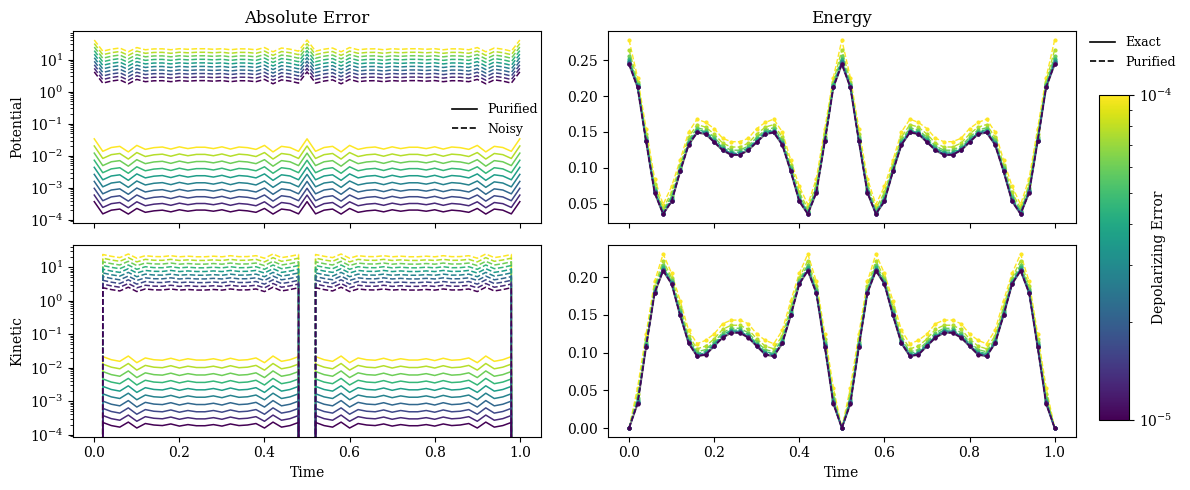

In [11]:
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.size": 10,
    "axes.linewidth": 0.8
})

fig, ((axU, axUE), (axT, axTE)) = plt.subplots(
    2, 2, figsize=(12, 5), sharex=True
)

# --- Scales ---
axU.set_yscale("log")
axT.set_yscale("log")

axUE.plot(times, U_exact, color='black', lw=1.5,alpha=0.5)
axTE.plot(times, T_exact, color='black', lw=1.5,alpha=0.5)

cmap = plt.cm.viridis
norm = plt_colors.LogNorm(vmin=lam.min(), vmax=lam.max())

for (d, lam_i) in (zip(data, lam[::-1])):
    color = cmap(norm(lam_i))

    
    # --- Errors ---
    axU.plot(times, np.abs(d[0] - U_exact),
             color=color, lw=1.1)

    axT.plot(times, np.abs(d[1] - T_exact),
             color=color, lw=1.1)

    axU.plot(times, np.abs(d[2] - U_exact),
             color=color, lw=1.1, ls='--')

    axT.plot(times, np.abs(d[3] - T_exact),
             color=color, lw=1.1, ls='--')

    # --- Representative trajectories ---

    axUE.plot(times, d[0], '--o',
                color=color, lw=1.0, ms=2)
    axTE.plot(times, d[1], '--o',
                color=color, lw=1.0, ms=2)
    
style_legend1 = [
    Line2D([0], [0], color='black', lw=1.2, label='Purified'),
    Line2D([0], [0], color='black', lw=1.2, ls='--', label='Noisy')
]

style_legend2 = [
    Line2D([0], [0], color='black', lw=1.2, label='Exact'),
    Line2D([0], [0], color='black', lw=1.2, ls='--', label='Purified')
]

axU.legend(
    handles=style_legend1,
    frameon=False,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(0.8, 0.65),  # just outside the axis
    borderaxespad=0.0
)

axU.set_title("Absolute Error")
axUE.set_title("Energy")

axT.set_xlabel("Time")
axTE.set_xlabel("Time")

axT.set_ylabel("Kinetic")
axU.set_ylabel("Potential")

axUE.legend(
    handles=style_legend2,
    frameon=False,
    fontsize=9,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0
)
# ======================================================
# Manually positioned colorbar (centered vertically)
# ======================================================
cax = fig.add_axes([0.92, 0.15, 0.025, 0.65])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Depolarizing Error', fontsize=10, labelpad=-15)

plt.tight_layout()
plt.savefig("NoisyEvo.pdf",dpi=300)
plt.show()